In [49]:
%matplotlib inline 
import numpy as np                       
from matplotlib import pyplot as plt      
import time, sys                   

## Задача Сода

Бесконечная труба заполнена воздухом ($\gamma = 1.4$), в точке $x = 0$ разделена перегородкой. При $t = 0$ слева от перегородки $(\rho, u, p)^T = (1, 0, 1)$, справа - $(\rho, u, p)^T = (0.125, 0, 0.1)$, где $\rho$ - плотность газа, $u$ - его скорость, $p$ - давление. Найти решение в момент времени $t\approx 0.504$. Считать воздух идеальным газом.

Уравнения газовой динамики и численный метод выписаны в книге [1], c.112-117. Там же приводятся графики решения, с которыми надо сверять свое решение.
1. Зализняк В.Е. Основы вычислительной физики. Часть 1. Введение в конечно-разностные методы

### Задание

Часть 1:
1. Реализовать все недостающие функции
2. Получить решение с постоянным шагом $\tau = 0.001$
3. Получить решение c $\tau_k = r\tau_{max}$, $\tau_{max}$ зависит от решения на текущем шаге. Постройте график зависимости $\tau_k$ от номера шага.
4. Прокомментировать решение, полученное в двух предыдущих пунктах
5. Укажите положение ударной волны и контактного разрыва
6. Прокомментируйте допустимость предложенного в коде варианта задания граничных условий. Стоит ли его заменить?

Часть 2: 
1. Реализуйте схему с искусственной вязкостью и проведите расчет в согласии с пунктом 3.
2. Прокомментируйте решение.

### Схема Лакса-Вендроффа для решения задачи Сода

Примитивные переменные $(\rho, u, p)^T$, консервативные - $(\rho, \rho u, \rho(e + u^2/2))$.

In [50]:
nx = 101  # количество узлов по пространству
h = 2 / (nx-1) # шаг по пространству
x_mesh = np.linspace(-1, 1, nx) #сетка по пространству
gamma = 1.4 # показатель адиабаты

In [51]:
# Пересчет прититивных переменных в консервативные
def primToCons(pv):
    rho = pv[0]
    u = pv[1]
    p = pv[2]
    ekin = 0.5*u**2
    return np.array([rho, rho*u, p/(gamma - 1) + rho*ekin])

# Пересчет консервативныx переменных в примитивные
def consToPrim(s):
    rho = s[0]
    u = s[1] / rho
    e = s[2] / rho - 0.5 * u**2
    p = (gamma - 1) * rho * e
    return np.array([rho, u, p])

# Вычисление потока f(s)
def flux(s):
    p = (gamma - 1) * (s[2] - 0.5 * s[1] ** 2 / s[0])
    return np.array([
        s[1],
        s[1] ** 2 / s[0] + p,
        s[1] * (s[2] + p) / s[0]
    ])

# Cхема Лакса-Вендроффа
# snm1, sn, snp1 - узлы шаблона со временного слоя k
def LaxWendroff(snm1, sn, snp1, tau, h):
    # Первый шаг - вычисление промежуточных значений в центрах ячеек
    fnm1 = flux(snm1)
    fn = flux(sn)
    fnp1 = flux(snp1)
    
    snm12 = 0.5*(snm1 + sn) - 0.5*(tau/h)*(fn - fnm1)
    snp12 = 0.5*(sn + snp1) - 0.5*(tau/h)*(fnp1 - fn)
    
    # Второй шаг - вычисление нового значения
    fnm12 = flux(snm12)
    fnp12 = flux(snp12)
    
    return sn - (tau/h)*(fnp12 - fnm12)

# Вычисление шага по времени
def get_tau(h, sk):
    max_speed = 0
    for s in sk:
        pv = consToPrim(s)
        u = pv[1]
        c = np.sqrt(gamma * pv[2] / pv[0]) # скорость звука
        speed = np.abs(u) + c
        if speed > max_speed:
            max_speed = speed
    tau_max = h / max_speed
     
    global t_var
    if t_var < 0.05:
        r = 0.5
    else:
        r = 0.9 # число Куранта
    return r * tau_max

#### Начальное условие

In [52]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

#### Численное решение

In [53]:
# Решение с постоянным шагом по времени
skp1_const = s0.copy()
sk_const = s0.copy()
t_const = 0
tau_const = 0.001
while t_const < 0.504:
    sk_const = skp1_const.copy()
    for n in range(1, nx-1):
        skp1_const[n] = LaxWendroff(sk_const[n-1], sk_const[n], sk_const[n+1], tau_const, h)
    # Граничные условия - постоянные значения на границах
    skp1_const[0] = primToCons(pvl)
    skp1_const[-1] = primToCons(pvr)
    t_const += tau_const

# Решение с переменным шагом по времени
skp1_var = s0.copy()
sk_var = s0.copy()
t_var = 0
tau_history = []
while t_var < 0.504:
    tau = get_tau(h, sk_var)
    tau_history.append(tau)
    sk_var = skp1_var.copy()
    for n in range(1, nx-1):
        skp1_var[n] = LaxWendroff(sk_var[n-1], sk_var[n], sk_var[n+1], tau, h)
    # Граничные условия - постоянные значения на границах
    skp1_var[0] = primToCons(pvl)
    skp1_var[-1] = primToCons(pvr)
    t_var += tau

#### Визуализация решения

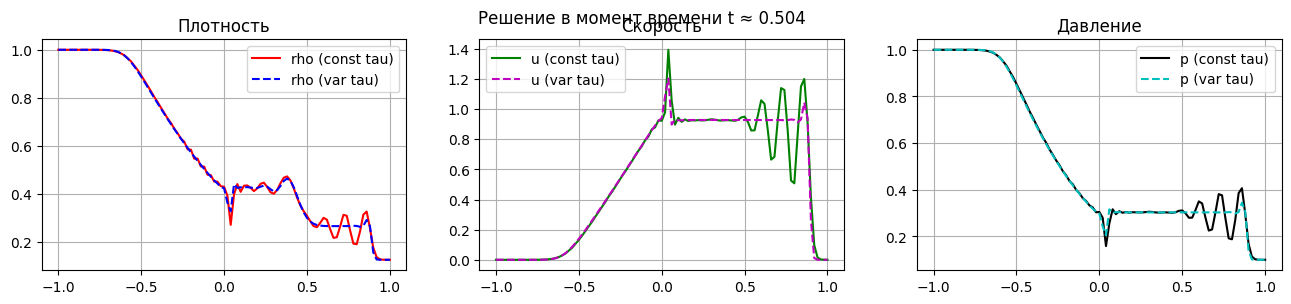

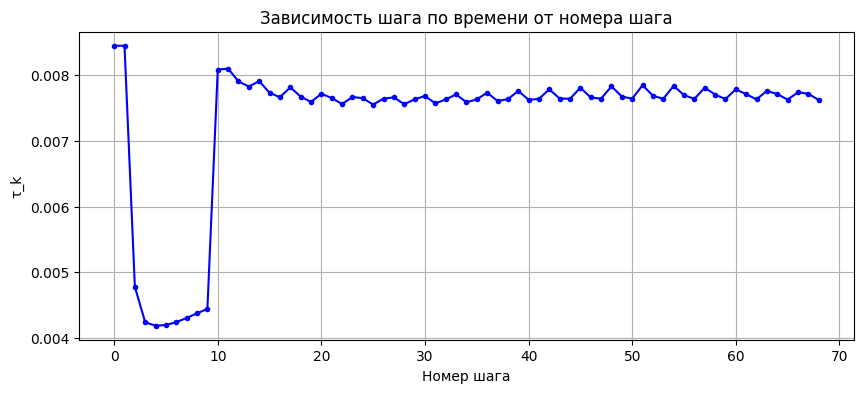

In [54]:
# Переводим решения в примитивные переменные
pv_res_const = np.array([consToPrim(s) for s in skp1_const])
pv_res_var = np.array([consToPrim(s) for s in skp1_var])

# Построение графиков
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res_const[:, 0], 'r', label='rho (const tau)')
axs[0].plot(x_mesh, pv_res_var[:, 0], 'b--', label='rho (var tau)')
axs[1].plot(x_mesh, pv_res_const[:, 1], 'g', label='u (const tau)')
axs[1].plot(x_mesh, pv_res_var[:, 1], 'm--', label='u (var tau)')
axs[2].plot(x_mesh, pv_res_const[:, 2], 'k', label='p (const tau)')
axs[2].plot(x_mesh, pv_res_var[:, 2], 'c--', label='p (var tau)')
for ax in axs:
    ax.legend()
    ax.grid()
axs[0].set_title('Плотность')
axs[1].set_title('Скорость')
axs[2].set_title('Давление')
fig.suptitle('Решение в момент времени t ≈ 0.504')

# График зависимости шага по времени от номера шага
plt.figure(figsize=(10, 4))
plt.plot(tau_history, 'b.-')
plt.xlabel('Номер шага')
plt.ylabel('τ_k')
plt.title('Зависимость шага по времени от номера шага')
plt.grid()
plt.show()

In [55]:
from matplotlib.animation import FuncAnimation


n_frames = 800  # Количество кадров
steps_per_frame = 5  # Шагов расчета между кадрами

# Подготовка данных для анимации
def simulate_shock_tube():
    sk = s0.copy()
    t = 0
    snapshots = []
    time_points = []
    
    while t < 0.504:
        if len(snapshots) < n_frames:
            pv_res = np.array([consToPrim(s) for s in sk])
            snapshots.append(pv_res.copy())
            time_points.append(t)
        
        tau = get_tau(h, sk)
        
        sk_new = sk.copy()
        
        for n in range(1, nx-1):
            sk_new[n] = LaxWendroff(sk[n-1], sk[n], sk[n+1], tau, h)

        sk_new[0] = primToCons(pvl)
        sk_new[-1] = primToCons(pvr)
        
        sk = sk_new
        t += tau
        
        if t >= 0.504:
            pv_res = np.array([consToPrim(s) for s in sk])
            snapshots.append(pv_res.copy())
            time_points.append(t)
            break
    
    return snapshots, time_points

# Симуляция
snapshots, time_points = simulate_shock_tube()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
plt.tight_layout()

def init():
    for ax in axs:
        ax.grid()
    axs[0].set_title('Плотность (ρ)')
    axs[1].set_title('Скорость (u)')
    axs[2].set_title('Давление (p)')
    return axs

def update(frame):
    for ax in axs:
        ax.clear()
    
    pv_res = snapshots[frame]
    
    axs[0].plot(x_mesh, pv_res[:, 0], 'r-')
    axs[1].plot(x_mesh, pv_res[:, 1], 'g-')
    axs[2].plot(x_mesh, pv_res[:, 2], 'b-')
    
    for ax in axs:
        ax.grid()
        ax.set_xlim(-1, 1)
    
    axs[0].set_ylim(0, 1.2)
    axs[1].set_ylim(-0.1, 1.0)
    axs[2].set_ylim(0, 1.2)
    
    fig.suptitle(f'Время t = {time_points[frame]:.3f}')
    return axs


ani = FuncAnimation(fig, update, frames=len(snapshots), init_func=init, blit=False)
ani.save('tube_t_var.gif', writer='pillow', fps=50, dpi=100)

plt.close()

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


n_frames = 800  # Количество кадров
steps_per_frame = 5  # Шагов расчета между кадрами

# Подготовка данных для анимации
def simulate_shock_tube():
    sk = s0.copy()
    t = 0
    snapshots = []
    time_points = []
    
    while t < 0.504:
        if len(snapshots) < n_frames:
            pv_res = np.array([consToPrim(s) for s in sk])
            snapshots.append(pv_res.copy())
            time_points.append(t)
        
        tau = 0.001
        
        sk_new = sk.copy()
        
        for n in range(1, nx-1):
            sk_new[n] = LaxWendroff(sk[n-1], sk[n], sk[n+1], tau, h)

        sk_new[0] = primToCons(pvl)
        sk_new[-1] = primToCons(pvr)
        
        sk = sk_new
        t += tau
        
        if t >= 0.504:
            pv_res = np.array([consToPrim(s) for s in sk])
            snapshots.append(pv_res.copy())
            time_points.append(t)
            break
    
    return snapshots, time_points

# Симуляция
snapshots, time_points = simulate_shock_tube()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
plt.tight_layout()

def init():
    for ax in axs:
        ax.grid()
    axs[0].set_title('Плотность (ρ)')
    axs[1].set_title('Скорость (u)')
    axs[2].set_title('Давление (p)')
    return axs

def update(frame):
    for ax in axs:
        ax.clear()
    
    pv_res = snapshots[frame]
    
    axs[0].plot(x_mesh, pv_res[:, 0], 'r-')
    axs[1].plot(x_mesh, pv_res[:, 1], 'g-')
    axs[2].plot(x_mesh, pv_res[:, 2], 'b-')
    
    for ax in axs:
        ax.grid()
        ax.set_xlim(-1, 1)
    
    axs[0].set_ylim(0, 1.2)
    axs[1].set_ylim(-0.1, 1.0)
    axs[2].set_ylim(0, 1.2)
    
    fig.suptitle(f'Время t = {time_points[frame]:.3f}')
    return axs


ani = FuncAnimation(fig, update, frames=len(snapshots), init_func=init, blit=False)
ani.save('tube_t_const.gif', writer='pillow', fps=50, dpi=100)

plt.close()

### Часть 1. Ответ.

Были написаны необходимые функции, получены графики решений через заданный промежуток для фиксированного $\tau$ и для переменного $\tau_k$.

Согласно рекомендациям из литературы на начальных этапах число Куранта было взять меньше, а для дальнейших шагов - 0.9.

Положение ударной волны ($x \approx 0.8$) характеризуется резким изменением всех параметров, а положение контактной волны ($x \approx 0.5$) только резким изменением плотности.

Так же можно заметить характерную для схем второго порядка **дисперсию**

Так же можно заметить две важных особенности:
1) В начальный момент времени $\tau_k$ больше, а после быстро падает и остается постоянным. Вероятнее всего это связано с тем, что в начальный момент система только приобретает скорости (в начальный момент скорость в системе меньше, чем после), а потом скорость в системе устаканивается и приобретает постоянный характер, из-за чего ограничение на $\tau$ не изменяется
2) Вариант решения с переменным параметром $\tau_k$ показывает лучший результат, осцилляции сильно меньше, чем с постоянным $\tau$. Хотя из графика для переменного $\tau_k$ видно, что решение при $\tau = 1$ будет устойчивым. С чем это связано не совсем понятно

По поводу предложенного варианта граничных условий. В этой задаче волна не доходит до краев (-1, 1), поэтому у нас не возникают никакие граничные условия. В случае, если бы нам потребовался более длинный промежуток времени достаточно было бы просто расширить пространственные границы

### 1. Консервативные переменные

$$
s = \begin{pmatrix}
\rho \\
\rho u \\
E
\end{pmatrix}, \quad
E = \rho \left( e + \frac{u^2}{2} \right)
$$

### 2. Потоки

$$
f(s) = \begin{pmatrix}
\rho u \\
\rho u^2 + p \\
u(E + p)
\end{pmatrix}, \quad
p = (\gamma - 1) \rho e
$$

### 3. Схема Лакса-Вендроффа (двухшаговая)

**Предиктор (полуцелые шаги):**

$$
s^{n+1/2}_{k+1/2} = \frac{1}{2} \left( s^n_k + s^{n+1}_k \right) - \frac{\tau}{2h} \left( f^{n+1}_k - f^n_k \right)
$$

**Корректор (полный шаг):**

$$
s^n_{k+1} = s^n_k - \frac{\tau}{h} \left( f^{n+1/2}_{k+1/2} - f^{n-1/2}_{k+1/2} \right)
$$

### 4. Условие устойчивости (Куранта)

$$
\tau_k = r \cdot \tau_{\text{max}}, \quad 
\tau_{\text{max}} = \frac{h}{\max \left( |u| + c \right)}, \quad 
c = \sqrt{\frac{\gamma p}{\rho}}
$$



## Часть 2. Схема Лакса-Вендроффа с искуственной взякостью

In [66]:
nx = 101  # количество узлов по пространству
h = 2 / (nx-1) # шаг по пространству
x_mesh = np.linspace(-1, 1, nx) #сетка по пространству
gamma = 1.4 # показатель адиабаты
nu = 0.05  # параметр искусственной вязкости

In [58]:
# Пересчет прититивных переменных в консервативные
def primToCons(pv):
    rho = pv[0]
    u = pv[1]
    p = pv[2]
    ekin = 0.5*u**2
    return np.array([rho, rho*u, p/(gamma - 1) + rho*ekin])

# Пересчет консервативныx переменных в примитивные
def consToPrim(s):
    rho = s[0]
    u = s[1] / rho
    e = s[2] / rho - 0.5 * u**2
    p = (gamma - 1) * rho * e
    return np.array([rho, u, p])

# Вычисление потока f(s)
def flux(s):
    p = (gamma - 1) * (s[2] - 0.5 * s[1] ** 2 / s[0])
    return np.array([
        s[1],
        s[1] ** 2 / s[0] + p,
        s[1] * (s[2] + p) / s[0]
    ])

# Cхема Лакса-Вендроффа
# snm1, sn, snp1 - узлы шаблона со временного слоя k
def LaxWendroffViscous(snm1, sn, snp1, tau, h):
    # Первый шаг - вычисление промежуточных значений в центрах ячеек
    fnm1 = flux(snm1)
    fn = flux(sn)
    fnp1 = flux(snp1)
    
    snm12 = 0.5*(snm1 + sn) - 0.5*(tau/h)*(fn - fnm1)
    snp12 = 0.5*(sn + snp1) - 0.5*(tau/h)*(fnp1 - fn)
    
    # Второй шаг - вычисление нового значения
    fnm12 = flux(snm12)
    fnp12 = flux(snp12)
    
    viscous_term = nu * (snm1 - 2*sn + snp1)
    return sn - (tau/h)*(fnp12 - fnm12) + viscous_term

# Вычисление шага по времени
def get_tau_visc(h, sk):
    max_speed = 0
    for s in sk:
        pv = consToPrim(s)
        u = pv[1]
        c = np.sqrt(gamma * pv[2] / pv[0]) # скорость звука
        speed = np.abs(u) + c
        if speed > max_speed:
            max_speed = speed
    tau_max = h / max_speed * np.sqrt(1 - 2 * nu)
     
    global t_var
    if t_var < 0.05:
        r = 0.5
    else:
        r = 0.9 # число Куранта
    return r * tau_max

In [67]:
s0 = np.zeros((nx, 3))
pvl = np.array([1,0,1])
pvr = np.array([0.125, 0, 0.1])
s0[:int(nx/2) + 1] = primToCons(pvl)
s0[int(nx/2) + 1:] = primToCons(pvr)

In [68]:
# Решение с переменным шагом по времени
skp1_var = s0.copy()
sk_var = s0.copy()
t_var = 0
tau_history = []

while t_var < 0.504:
    tau = get_tau_visc(h, sk_var)
    tau_history.append(tau)
    sk_var = skp1_var.copy()
    for n in range(1, nx-1):
        skp1_var[n] = LaxWendroffViscous(sk_var[n-1], sk_var[n], sk_var[n+1], tau, h)
    # Граничные условия - постоянные значения на границах
    skp1_var[0] = primToCons(pvl)
    skp1_var[-1] = primToCons(pvr)
    t_var += tau

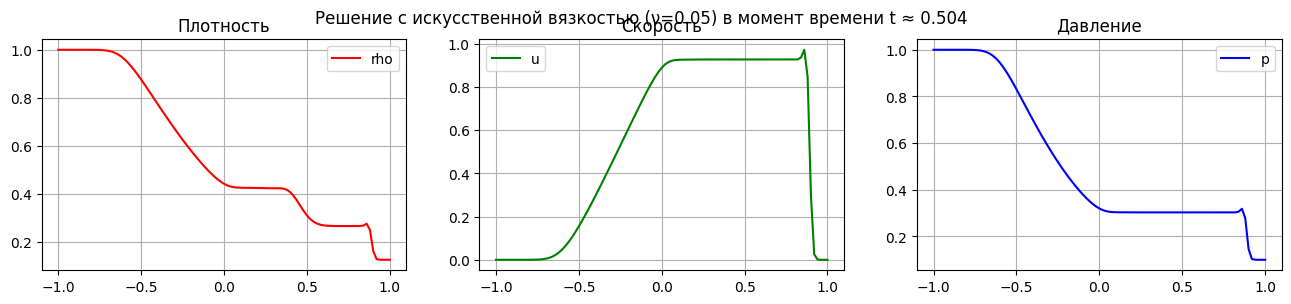

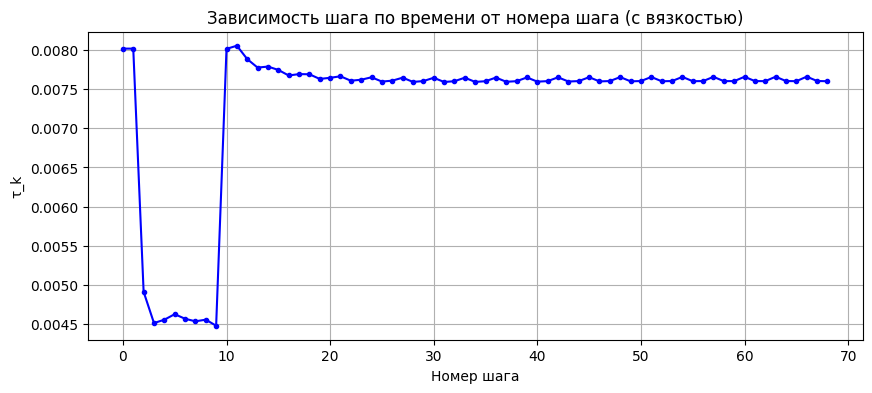

In [69]:
# Переводим решение в примитивные переменные
pv_res_var = np.array([consToPrim(s) for s in skp1_var])

# Построение графиков
fig, axs = plt.subplots(1, 3, figsize=(16, 3))
axs[0].plot(x_mesh, pv_res_var[:, 0], 'r', label='rho')
axs[1].plot(x_mesh, pv_res_var[:, 1], 'g', label='u')
axs[2].plot(x_mesh, pv_res_var[:, 2], 'b', label='p')
for ax in axs:
    ax.legend()
    ax.grid()
axs[0].set_title('Плотность')
axs[1].set_title('Скорость')
axs[2].set_title('Давление')
fig.suptitle(f'Решение с искусственной вязкостью (ν={nu}) в момент времени t ≈ 0.504')

# График зависимости шага по времени от номера шага
plt.figure(figsize=(10, 4))
plt.plot(tau_history, 'b.-')
plt.xlabel('Номер шага')
plt.ylabel('τ_k')
plt.title('Зависимость шага по времени от номера шага (с вязкостью)')
plt.grid()
plt.show()

In [62]:
from matplotlib.animation import FuncAnimation


n_frames = 800  # Количество кадров
steps_per_frame = 5  # Шагов расчета между кадрами

# Подготовка данных для анимации
def simulate_shock_tube():
    sk = s0.copy()
    t = 0
    snapshots = []
    time_points = []
    
    while t < 0.504:
        if len(snapshots) < n_frames:
            pv_res = np.array([consToPrim(s) for s in sk])
            snapshots.append(pv_res.copy())
            time_points.append(t)
        
        tau = get_tau_visc(h, sk)
        
        sk_new = sk.copy()
        
        for n in range(1, nx-1):
            sk_new[n] = LaxWendroffViscous(sk[n-1], sk[n], sk[n+1], tau, h)

        sk_new[0] = primToCons(pvl)
        sk_new[-1] = primToCons(pvr)
        
        sk = sk_new
        t += tau
        
        if t >= 0.504:
            pv_res = np.array([consToPrim(s) for s in sk])
            snapshots.append(pv_res.copy())
            time_points.append(t)
            break
    
    return snapshots, time_points

# Симуляция
snapshots, time_points = simulate_shock_tube()

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
plt.tight_layout()

def init():
    for ax in axs:
        ax.grid()
    axs[0].set_title('Плотность (ρ)')
    axs[1].set_title('Скорость (u)')
    axs[2].set_title('Давление (p)')
    return axs

def update(frame):
    for ax in axs:
        ax.clear()
    
    pv_res = snapshots[frame]
    
    axs[0].plot(x_mesh, pv_res[:, 0], 'r-')
    axs[1].plot(x_mesh, pv_res[:, 1], 'g-')
    axs[2].plot(x_mesh, pv_res[:, 2], 'b-')
    
    for ax in axs:
        ax.grid()
        ax.set_xlim(-1, 1)
    
    axs[0].set_ylim(0, 1.2)
    axs[1].set_ylim(-0.1, 1.0)
    axs[2].set_ylim(0, 1.2)
    
    fig.suptitle(f'Время t = {time_points[frame]:.3f}')
    return axs


ani = FuncAnimation(fig, update, frames=len(snapshots), init_func=init, blit=False)
ani.save('tube_t_visc.gif', writer='pillow', fps=50, dpi=100)

plt.close()

### Модифицированная система

$$
\frac{\partial s}{\partial t} + \frac{\partial f(s)}{\partial x} = \nu \frac{\partial^2 s}{\partial x^2},
$$

$$
\nu = \mu \frac{\tau_k}{a_k}
$$



### Схема Лакса-Вендроффа с вязкостью

$$
s^n_{k+1} = s^n_k - \frac{\tau_k}{h} \left( f^{n+1/2}_{k+1/2} - f^{n-1/2}_{k+1/2} \right) + \nu \left( s^{n+1}_k - 2s^n_k + s^{n-1}_k \right)
$$


### Условие устойчивости

$$
\tau_k \leq \tau_{\text{max}} \sqrt{1 - 2{\nu}}, \quad 
\tau_{\text{max}} = \frac{h}{\max\left( |u| + c \right)}
$$

Полченное уравнение отличается добавлением члена второго порядка, называемым искуственной вязкостью, которая сохраняет характер решения, однако приводит к затуханию высокочастотных компонентов решения в процессе вычисления, что приводит к подавлению нефизических осцилляций разностного решения.

Данный член имеет диссипативный характер.

С вязкостью у нас подавляются осцилляции, но и теряется резкость фронтов ударных и контактных волн.